In [2]:
import tensorflow as tf
import keras
from keras.layers import Conv2DTranspose, UpSampling2D, Conv2D, BatchNormalization, Activation, Concatenate, Dropout, MaxPooling2D, Input, LeakyReLU
from keras.models import Model
import copy
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/UltraDuke#/ultraduke_verasonics_mark

/content/drive/MyDrive/UltraDuke/ultraduke_verasonics_mark


In [5]:
pip install polarTransform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 2.1 MB/s eta 0:00:00


In [66]:
import tensorflow as tf
import scipy.io as sio
import numpy as np
import polarTransform
import pandas as pd
from functools import partial

DEFAULT_BUCKET_DIR = ''

class MimickDataset():
    def __init__(self, clipping=(-80,0), divisible=16, sc=False, shape=None, image_dir=None, bucket_dir=DEFAULT_BUCKET_DIR):
        self.image_dir = bucket_dir if image_dir is None else image_dir
        self.clipping = clipping
        self.sc = sc
        self.divisible = divisible
        self.shape = shape

    def read_mat_op(self, filename, irad, frad, iang, fang):
        filepath = tf.io.gfile.GFile('{}/{}'.format(self.image_dir, filename.numpy().decode()), 'rb')
        matfile = sio.loadmat(filepath)

        # normalize dtce to [0, 1]
        dtce = matfile['dtce']
        dtce = (dtce - dtce.min())/(dtce.max() - dtce.min())

        # signal detect, clip, and normalize
        iq = np.abs(matfile['iq'])
        if self.clipping is not None:
            iq = 20*np.log10(iq/iq.max())
            iq = np.clip(iq, self.clipping[0], self.clipping[1])
        else:
            iq = np.log10(iq)
        iq = (iq-iq.min())/(iq.max() - iq.min())

        if self.sc: # scan convert TODO (this process is heavy so it should be preprocessed)
            iq = scan_convert(iq, irad.numpy(), frad.numpy(), iang.numpy(), fang.numpy())
            dtce = scan_convert(dtce, irad.numpy(), frad.numpy(), iang.numpy(), fang.numpy())

        seed = np.random.randint(0, 2147483647)
        iq, _ = make_shape(iq, shape=self.shape, divisible=self.divisible, seed=seed)
        dtce, _ = make_shape(dtce, shape=self.shape, divisible=self.divisible, seed=seed)
        return iq.astype('float32'), dtce.astype('float32')

    def get_dataset(self, csv):
        count = len(pd.read_csv(csv))
        dataset = tf.data.experimental.make_csv_dataset(csv, shuffle=False, batch_size=1).unbatch()
        dataset = dataset.shuffle(count).repeat()
        images  = dataset.map(lambda x: tf.py_function(self.read_mat_op, [x['filename'],
                                                                          x['initial_radius'], x['final_radius'],
                                                                          x['initial_angle'], x['final_angle']], [tf.float32, tf.float32]),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = tf.data.Dataset.zip((images, dataset))
        dataset = dataset.map(lambda x, y: (x[0], x[1], y))
        return dataset, count

    def get_paired_ultrasound_dataset(self, csv='gs://duke-research-us/mimicknet/data/training-v1.csv', batch_size=16):
        dataset, count = self.get_dataset(csv)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(batch_size)
        return dataset, count

    def get_unpaired_ultrasound_dataset(self, domain, csv=None, batch_size=16):
        if domain == 'iq':
            csv = 'gs://duke-research-us/mimicknet/data/training_a-v1.csv' if csv is None else csv
            dataset, count = self.get_dataset(csv)
            dataset = dataset.map(lambda iq, dtce, params: (iq, params))

        elif domain == 'dtce':
            csv = 'gs://duke-research-us/mimicknet/data/training_b-v1.csv' if csv is None else csv
            dataset, count = self.get_dataset(csv)
            dataset = dataset.map(lambda iq, dtce, params: (dtce, params))
        else:
            raise Exception('domain must be "iq" or "dtce", given {}'.format(domain))

        dataset = dataset.batch(batch_size).prefetch(batch_size)
        return dataset, count


def make_shape(image, shape=None, divisible=16, seed=0):
    """Will reflection pad or crop to make an image divisible by a number.

    If shape is smaller than the original image, it will be cropped randomly
    If shape is larger than the original image, it will be refection padded
    If shape is None, the image's original shape will be minimally padded to be divisible by a number.

    Arguments:
        image {np.array} -- np.array that is (height, width, channels)

    Keyword Arguments:
        shape {tuple} -- shape of image desired (default: {None})
        seed {number} -- random seed for random cropping (default: {0})
        divisible {number} -- number to be divisible by (default: {16})

    Returns:
        np.array, (int, int) -- divisible image no matter the shape, and a tuple of the original size.
    """

    np.random.seed(seed=seed)
    image_height = image.shape[0]
    image_width = image.shape[1]

    shape = shape if shape is not None else image.shape
    height = shape[0] if shape[0] % divisible == 0 else (divisible - shape[0] % divisible) + shape[0]
    width = shape[1] if shape[1] % divisible == 0 else (divisible - shape[1] % divisible) + shape[1]

    # Pad data to batch height and width with reflections, and randomly crop
    if image_height < height:
        remainder = height - image_height
        if remainder % 2 == 0:
            image = np.pad(image, ((int(remainder/2), int(remainder/2)), (0,0)), 'reflect')
        else:
            remainder = remainder - 1
            image = np.pad(image, ((int(remainder/2) + 1, int(remainder/2)), (0,0)), 'reflect')
    elif image_height > height:
        start = np.random.randint(0, image_height - height)
        image = image[start:start+height, :]

    if image_width < width:
        remainder = width - image_width
        if remainder % 2 == 0:
            image = np.pad(image, ((0,0), (int(remainder/2), int(remainder/2))), 'reflect')
        else:
            remainder = remainder - 1
            image = np.pad(image, ((0,0), (int(remainder/2) + 1, int(remainder/2))), 'reflect')
    elif image_width > width:
        start = np.random.randint(0, image_width - width)
        image = image[:, start:start+width]
    image = image[:,:, None]

    return image, (image_height, image_width)

def scan_convert(image, irad, frad, iang, fang):
    image, _ = polarTransform.convertToCartesianImage(
        np.transpose(image),
        initialRadius=irad,
        finalRadius=frad,
        initialAngle=iang,
        finalAngle=fang,
        hasColor=False,
        order=1)
    return np.transpose(image[:, int(irad):])

In [67]:
# Load Data (Build your custom data loader and replace below)
mimick = MimickDataset(
    clipping=None,
    image_dir="ultraduke_verasonics_phantom",
    shape=(512, 512)
)

iq_dataset, iq_count = mimick.get_unpaired_ultrasound_dataset(
    domain='iq',
    csv="ultraduke_training_a-v2-verasonics-phantom.csv",
    batch_size=8
)
iq_dataset = iq_dataset.map(lambda x,z: x)

dtce_dataset, dtce_count = mimick.get_unpaired_ultrasound_dataset(
    domain='dtce',
    csv="ultraduke_training_b-v2-verasonics-phantom.csv",
    batch_size=8
)
dtce_dataset = dtce_dataset.map(lambda x,z: x)

In [28]:
class ConvDropoutNormNonlin(tf.keras.layers.Layer):

    def __init__(self, filters,
                 conv_op=Conv2D,
                 norm_op=BatchNormalization,
                 dropout_op=Dropout,
                 nonlin=LeakyReLU):
        super().__init__()

        self.nonlin = nonlin
        self.dropout_op = dropout_op
        self.conv_op = conv_op
        self.norm_op = norm_op

        self.conv = self.conv_op(filters=filters,kernel_size=3,strides=(1,1),padding="same")
        if self.dropout_op:
            self.dropout = self.dropout_op(0.5)
        self.instnorm = self.norm_op()
        self.lrelu = self.nonlin(alpha=1e-2)

    def call(self, inputs):
        x = self.conv(inputs)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.instnorm(x)
        return self.lrelu(x)

In [11]:
class StackedConvLayers(tf.keras.layers.Layer):
    def __init__(self, num_convs, filters,
                 conv_op=Conv2D,
                 norm_op=BatchNormalization,
                 dropout_op=Dropout,
                 nonlin=LeakyReLU, basic_block=ConvDropoutNormNonlin):

        super().__init__()

        self.nonlin = nonlin
        self.dropout_op = dropout_op
        self.conv_op = conv_op
        self.norm_op = norm_op

        self.blocks = keras.models.Sequential(
            [basic_block(filters,self.conv_op,
                           self.norm_op, self.dropout_op,
                           self.nonlin) for _ in range(num_convs)])
        #self.blocks.add(MaxPooling2D((2,2)))
    def call(self, inputs):
        return self.blocks(inputs)

In [12]:
class UpSample(tf.keras.layers.Layer):
  def __init__(self,size):
    super().__init__()
    self.size = size
    self.upsample = UpSampling2D(size=size)

  def call(self,inputs):
    return self.upsample(inputs)

In [76]:
class PatchDiscriminator(tf.keras.layers.Layer):
  def __init__(self,filters,shape,padding='valid'):
    super().__init__()
    self.filters = filters
    self.shape = shape
    self.padding = padding

  def __call__(self):
    inputs = Input(shape=self.shape)
    x = inputs
    for filter_num in self.filters:
      x = Conv2D(filters=filter_num,kernel_size=(3,3))(x)
      x = Activation('relu')(x)
      x = MaxPooling2D(padding=self.padding)(x)
    validity = tf.keras.layers.Conv2D(1, (self.shape[0]//(2**(len(self.filters)+1)),
                                          self.shape[1]//(2**(len(self.filters)+1))), padding=self.padding)(x)
    return tf.keras.Model(inputs, validity)

In [14]:
class UnetPlusPlus(tf.keras.models.Model):
  def __init__(self):#,dims):
    super().__init__()
    self.conv_blocks_context = []
    self.loc0 = []
    self.loc1 = []
    self.loc2 = []
    self.loc3 = []
    self.loc4 = []
    self.td = []
    self.up0 = []
    self.up1 = []
    self.up2 = []
    self.up3 = []
    self.up4 = []
    self.seg_outputs = []
    self.convs_per_block = 2
    self.num_pool = 5
    self.pool_op_kernel_size = [(2,2)] * self.num_pool
    self.conv_op_filter_count = [16,32,64,128,256]
    #self.inputs = Input(shape=dims)
    for i in range(self.num_pool):
      self.conv_blocks_context.append(StackedConvLayers(num_convs=self.convs_per_block,filters=self.conv_op_filter_count[i]))
      #self.conv_blocks_context.append(MaxPooling2D((2,2)))
    self.conv_blocks_context.append(keras.models.Sequential([StackedConvLayers(num_convs=self.convs_per_block-1,filters=self.conv_op_filter_count[-1]),StackedConvLayers(num_convs=1,filters=self.conv_op_filter_count[-1])]))
    self.loc0, self.up0 = self.create_nest(0)
    self.loc1, self.up1 = self.create_nest(1)
    self.loc2, self.up2 = self.create_nest(2)
    self.loc3, self.up3 = self.create_nest(3)
    self.loc4, self.up4 = self.create_nest(4)

  def create_nest(self,z,num_pool=5):
    conv_blocks_localization = []
    upsample_blocks_localization = []
    for u in range(z,num_pool):
      upsample_blocks_localization.append(UpSample(self.pool_op_kernel_size[-(u+1)]))
      if u == num_pool - 1:
        conv_blocks_localization.append(keras.models.Sequential([StackedConvLayers(num_convs=self.convs_per_block-1,filters=self.conv_op_filter_count[-u]),StackedConvLayers(num_convs=1,filters=1)]))
        continue
      conv_blocks_localization.append(keras.models.Sequential([StackedConvLayers(num_convs=self.convs_per_block-1,filters=self.conv_op_filter_count[-u]),StackedConvLayers(num_convs=1,filters=self.conv_op_filter_count[-u])]))
    return conv_blocks_localization, upsample_blocks_localization

  def call(self,inputs):

    x0_0 = self.conv_blocks_context[0](inputs)
    x1_0 = self.conv_blocks_context[1](x0_0)
    x1_0 = MaxPooling2D((2,2))(x1_0)
    ##print(x1_0.shape)
    x0_1 = self.loc4[0](Concatenate()([x0_0,self.up4[0](x1_0)]))

    x2_0 = self.conv_blocks_context[2](x1_0)
    x2_0 = MaxPooling2D((2,2))(x2_0)
    ##print(x1_0.shape)
    ##print(x2_0.shape)
    ##print(self.conv_blocks_context)
    x1_1 = self.loc3[0](Concatenate()([x1_0, self.up3[0](x2_0)]))
    ##x1_1 = MaxPooling2D((2,2))(x1_1)
    x0_2 = self.loc3[1](Concatenate()([x0_0, x0_1, self.up3[1](x1_1)]))

    x3_0 = self.conv_blocks_context[3](x2_0)
    x3_0 = MaxPooling2D((2,2))(x3_0)
    x2_1 = self.loc2[0](Concatenate()([x2_0, self.up2[0](x3_0)]))
    x1_2 = self.loc2[1](Concatenate()([x1_0, x1_1, self.up2[1](x2_1)]))
    x0_3 = self.loc2[2](Concatenate()([x0_0, x0_1, x0_2, self.up2[2](x1_2)]))

    x4_0 = self.conv_blocks_context[4](x3_0)
    x4_0 = MaxPooling2D((2,2))(x4_0)
    x3_1 = self.loc1[0](Concatenate()([x3_0, self.up1[0](x4_0)]))
    x2_2 = self.loc1[1](Concatenate()([x2_0, x2_1, self.up1[1](x3_1)]))
    x1_3 = self.loc1[2](Concatenate()([x1_0, x1_1, x1_2, self.up1[2](x2_2)]))
    x0_4 = self.loc1[3](Concatenate()([x0_0, x0_1, x0_2, x0_3, self.up1[3](x1_3)]))

    x5_0 = self.conv_blocks_context[5](x4_0)
    x5_0 = MaxPooling2D((2,2))(x5_0)
    x4_1 = self.loc0[0](Concatenate()([x4_0, self.up0[0](x5_0)]))
    x3_2 = self.loc0[1](Concatenate()([x3_0, x3_1, self.up0[1](x4_1)]))
    x2_3 = self.loc0[2](Concatenate()([x2_0, x2_1, x2_2, self.up0[2](x3_2)]))
    x1_4 = self.loc0[3](Concatenate()([x1_0, x1_1, x1_2, x1_3, self.up0[3](x2_3)]))
    x0_5 = self.loc0[4](Concatenate()([x0_0, x0_1, x0_2, x0_3, x0_4, self.up0[4](x1_4)]))

    return x0_5

In [69]:
class CycleGAN:
    def __init__(self, g_AB=None, g_BA=None, d_B=None, d_A=None, shape = (None, None, 1)):
        self.shape = shape

        if d_A is None or d_B is None or g_AB is None or g_BA is None:
            raise Exception('d_A, d_B, g_AB, or g_BA cannot be None and must be a `tf.keras.Model`')
        self.d_A = d_A
        self.d_B = d_B
        self.g_AB = g_AB
        self.g_BA = g_BA

    def compile(self, optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=[], d_loss='mse',
                g_loss = [
                    'mse', 'mse',
                    'mae', 'mae',
                    'mae', 'mae'
                ], loss_weights = [
                     1,  1,
                    10, 10,
                     1,  1
                ]):
        self.optimizer = optimizer
        self.metrics = metrics
        self.d_loss = d_loss
        self.g_loss = g_loss
        self.loss_weights = loss_weights

        self.d_A.compile(loss=self.d_loss, optimizer=self.optimizer, metrics=['accuracy'])
        self.d_B.compile(loss=self.d_loss, optimizer=self.optimizer, metrics=['accuracy'])

        # Build the generator block
        self.d_A.trainable = False
        self.d_B.trainable = False

        img_A = tf.keras.layers.Input(shape=self.shape)   # Input images from both domains
        img_B = tf.keras.layers.Input(shape=self.shape)
        fake_B = self.g_AB(img_A)                         # Translate images to the other domain
        fake_A = self.g_BA(img_B)
        reconstr_A = self.g_BA(fake_B)                    # Translate images back to original domain
        reconstr_B = self.g_AB(fake_A)
        img_A_id = self.g_BA(img_A)                       # Identity mapping of images
        img_B_id = self.g_AB(img_B)

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = tf.keras.Model(inputs  = [img_A, img_B],
                                       outputs = [valid_A, valid_B,
                                                  reconstr_A, reconstr_B,
                                                  img_A_id, img_B_id])
        self.combined.compile(loss=self.g_loss,
                              loss_weights=self.loss_weights,
                              optimizer=self.optimizer)


    def validate(self, validation_steps):
        metrics_summary = {}
        for metric in self.metrics:
            metrics_summary[metric.__name__] = []

        for step in range(validation_steps):
            val_batch = next(self.dataset_val_next)
            B_batch = val_batch[1]
            fake_B = self.g_AB.predict(val_batch[0])

            for metric in self.metrics:
                metric_output = metric(tf.constant(B_batch), tf.constant(fake_B)).numpy()
                metrics_summary[metric.__name__].append(metric_output[0])

        # average all metrics
        for key, value in metrics_summary.items():
            self.log['val_' + key] = np.mean(value)

        return metrics_summary

    def _fit_init(self, dataset_a, dataset_b, batch_size, steps_per_epoch, epochs, validation_data, callbacks, verbose):
        """Initialize Callbacks and Datasets"""
        self.stop_training = False # Flag for early stopping

        if not hasattr(self, 'dataset_next_a'):
            self.dataset_a_next = iter(dataset_a)
            self.dataset_b_next = iter(dataset_b)
            metric_names = ['d_loss', 'd_acc', 'g_loss', 'adv_loss', 'recon_loss', 'id_loss', 'lr']
            metric_names.extend([metric.__name__ for metric in self.metrics])

        if not hasattr(self, 'dataset_val_next') and validation_data is not None:
            self.dataset_val_next = iter(validation_data)
            metric_names.extend(['val_' + name for name in metric_names])

        for callback in callbacks:
            callback.set_model(self.g_AB) # only set callbacks to the forward generator
            callback.set_params({
                'verbose': verbose,
                'epochs': epochs,
                'steps': steps_per_epoch,
                'metrics': metric_names # for tensorboard callback to know which metrics to log
            })

        self.log = {
            'size': batch_size
        }

    def train_step(self):
        a_batch = next(self.dataset_a_next)
        b_batch = next(self.dataset_b_next)

        self.patch_gan_size = (a_batch.shape[0],) + self.d_A.get_output_shape_at(0)[1:]
        self.valid = np.ones(self.patch_gan_size)
        self.fake = np.zeros(self.patch_gan_size)

        # Translate images to opposite domain
        fake_B = self.g_AB.predict(a_batch)
        fake_A = self.g_BA.predict(b_batch)

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = self.d_A.train_on_batch(a_batch, self.valid)
        dA_loss_fake = self.d_A.train_on_batch(fake_A, self.fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = self.d_B.train_on_batch(b_batch, self.valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B, self.fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        d_loss = 0.5 * np.add(dA_loss, dB_loss)

        g_loss = self.combined.train_on_batch([a_batch, b_batch],
                                              [self.valid, self.valid,
                                               a_batch, b_batch,
                                               a_batch, b_batch])

        self.log['d_loss'] = d_loss[0]
        self.log['d_acc'] = 100*d_loss[1]
        self.log['g_loss'] = g_loss[0]
        self.log['adv_loss'] = np.mean(g_loss[1:3])
        self.log['recon_loss'] = np.mean(g_loss[3:5])
        self.log['id_loss'] = np.mean(g_loss[5:6])

    def fit(self, dataset_a, dataset_b, batch_size=8, steps_per_epoch=10, epochs=3, validation_data=None, verbose=1, validation_steps=10,
            callbacks=[]):
        self._fit_init(dataset_a, dataset_b, batch_size, steps_per_epoch, epochs, validation_data, callbacks, verbose)
        for callback in callbacks: callback.on_train_begin(logs=self.log)
        for epoch in range(epochs):
            for callback in callbacks: callback.on_epoch_begin(epoch, logs=self.log)
            for step in range(steps_per_epoch):
                for callback in callbacks: callback.on_batch_begin(step, logs=self.log)
                self.train_step()
                for callback in callbacks: callback.on_batch_end(step, logs=self.log)

            if validation_data is not None:
                forward_metrics = self.validate(validation_steps)

            for callback in callbacks: callback.on_epoch_end(epoch, logs=self.log)
        for callback in callbacks: callback.on_train_end(logs=self.log)

In [77]:
ModelClass = UnetPlusPlus
g_AB = ModelClass()
g_BA = ModelClass()
d_A = PatchDiscriminator(shape=(512, 512, 1),
                                     filters=[32, 64, 128, 256, 512])()
d_B = PatchDiscriminator(shape=(512, 512, 1),
                                     filters=[32, 64, 128, 256, 512])()

model = CycleGAN(shape = (None, None, 1),
                        g_AB=g_AB,
                        g_BA=g_BA,
                        d_B=d_B,
                        d_A=d_A)

# Compile Model and Set Lambda Hyperparams
model.compile(optimizer=tf.keras.optimizers.Adam(0.00002, 0.5),
              d_loss='mse',
              g_loss = [
                 'mse', 'mse',
                 'mse', 'mse',
                 'mse', 'mse'
              ], loss_weights = [
                 1,  1,
                 10, 10,
                 1,  1
              ],
              metrics=[])

In [79]:
model.fit(iq_dataset, dtce_dataset,
          steps_per_epoch=int(iq_count/8),
          epochs=50,
          #validation_data=test_dataset,
          #validation_steps=int(val_count/8),
          callbacks=[])

TypeError: ignored

In [15]:
network = UnetPlusPlus()#dims=(512,512,3))
network.build(input_shape=(None,512,512,1))
network.summary()

Model: "unet_plus_plus"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stacked_conv_layers (Stacke  multiple                 2608      
 dConvLayers)                                                    
                                                                 
 stacked_conv_layers_1 (Stac  multiple                 14144     
 kedConvLayers)                                                  
                                                                 
 stacked_conv_layers_2 (Stac  multiple                 55936     
 kedConvLayers)                                                  
                                                                 
 stacked_conv_layers_3 (Stac  multiple                 222464    
 kedConvLayers)                                                  
                                                                 
 stacked_conv_layers_4 (Stac  multiple              

In [64]:
test = None
for sample in dtce_dataset:
  test = sample
  break

#out = network.predict(test)

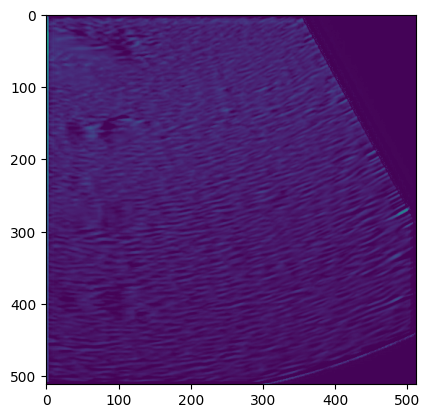

In [57]:
plt.imshow(out[0])

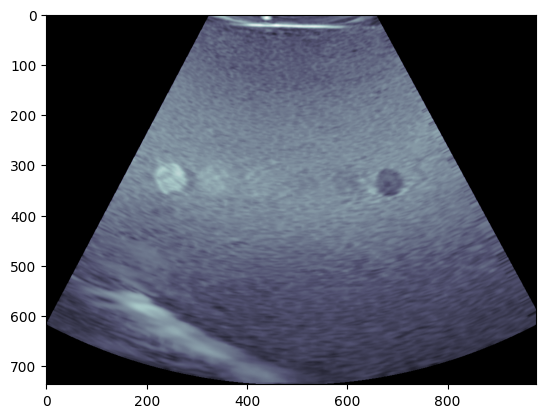

In [65]:
plt.imshow(test[0],cmap='bone')